### Environment Setup

In [1]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import ceil
from numpy.linalg import inv
from scipy import interpolate

from scipy.optimize import minimize
from sklearn.metrics import r2_score

%matplotlib inline

### Downloading File

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-726298249/sub-726298249_ses-754829445.nwb"
# dandiset_id = "000563"
# dandi_filepath = "sub-688546/sub-688546_ses-1295360519.nwb"
download_loc = "."
dandi_api_key = os.environ["DANDI_API_KEY"]

In [4]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.59.1) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### The GLM

In [5]:
def neg_log_lik_lnp(theta, X, y, Cinv):
  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta)
  log_lik = y @ np.log(rate) - rate.sum()
  log_lik -= theta.T @ Cinv @ theta

  return -log_lik

In [6]:
def fit_lnp(X, y, d=25, lam=0):
  Imat = np.identity(d+1) # identity matrix of size of filter + const
  Imat[0,0] = 0
  Cinv = lam*Imat

  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, d + 1)
  print("y:",y.shape,"X:",X.shape,"x0:",x0.shape)

  # Find parameters that minmize the negative log likelihood function
  res = minimize(neg_log_lik_lnp, x0, args=(X, y, Cinv))

  return res["x"][0], res["x"][1:]

### Synthetic Data

0.0 300.0
30000


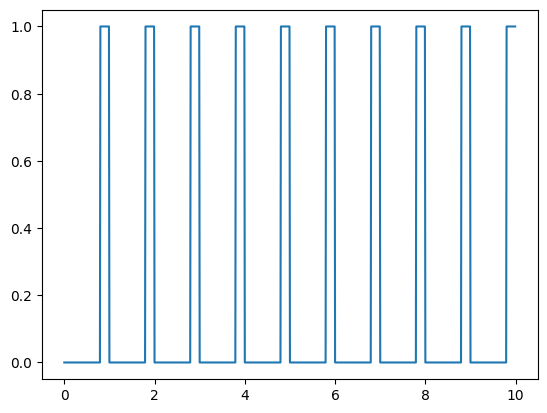

In [7]:
def make_flashes(time_start, time_end, pattern, n_repeats):
    flashes = np.tile(pattern, n_repeats)
    time_axis = np.linspace(time_start, time_end, len(flashes))
    return time_axis, flashes

syn_time_axis, syn_flashes = make_flashes(0, 300, [0]*80 + [1]*20, 300)
print(syn_time_axis[0], syn_time_axis[-1])
print(len(syn_flashes))
plt.plot(syn_time_axis[:1000], syn_flashes[:1000])

2.117000016612675 1.0512710963760241
30000


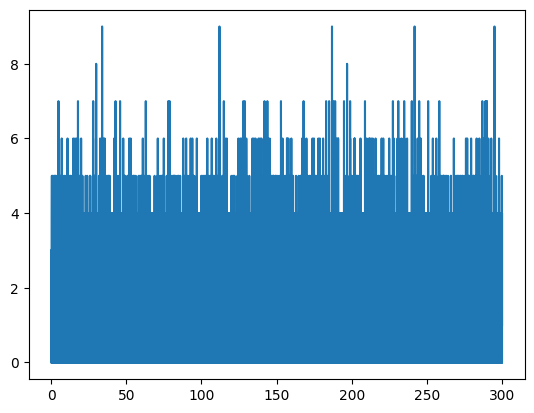

In [8]:
def make_spikes(stim, baseline_rate, coeff, return_exp=False):
    weighted_stim = (stim*coeff) + baseline_rate
    exp_stim = np.exp(weighted_stim)
    print(np.max(exp_stim), np.min(exp_stim))
    spikes = np.random.poisson(exp_stim)
    if return_exp:
        return spikes[1:], weighted_stim, exp_stim
    return spikes

syn_spikes_binned = make_spikes(syn_flashes, 0.05, 0.7)
print(len(syn_spikes_binned))
plt.plot(syn_time_axis, syn_spikes_binned)

### Design Matrix

In [9]:
def build_design_mat(stim, d):
  constant = np.ones_like(stim)

  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d - 1), stim])

  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t + d]

  design_matrix = np.column_stack([constant, X])
  return design_matrix

(30000, 26)


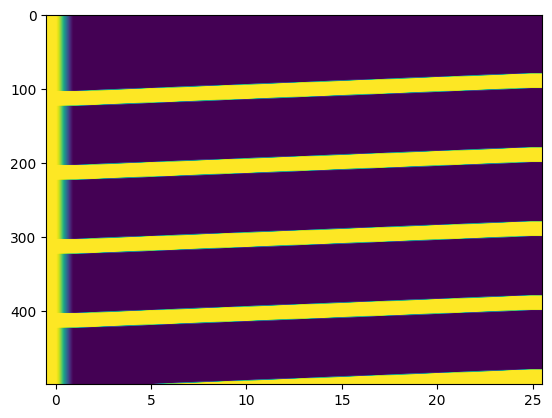

In [10]:
syn_design_mat = build_design_mat(syn_flashes, 25)
print(syn_design_mat.shape)
plt.imshow(syn_design_mat[:500], aspect="auto")

### Running on Synthetic Data

y: (30000,) X: (30000, 26) x0: (26,)
0.08715590406596474


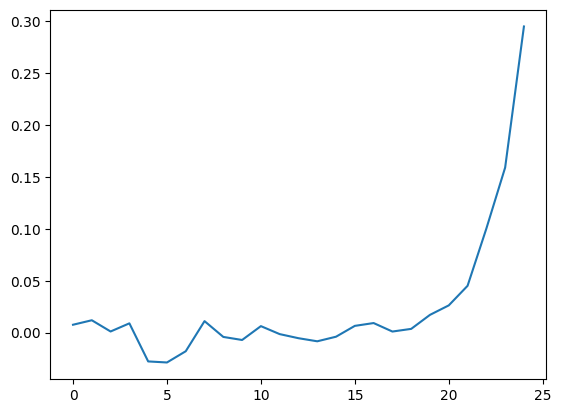

In [11]:
constant, filter = fit_lnp(syn_design_mat, syn_spikes_binned, d=25, lam=2**10)
print(constant)
plt.plot(filter)

In [12]:
coeff_in = []
coeff_out = []
constant_out = []
for i in range(10):
    # n_repeats = 2**i
    n_repeats = 2**11
    time_axis, syn_flashes = make_flashes(0, n_repeats, [0]*80 + [1]*20, n_repeats)
    design_mat = build_design_mat(syn_flashes, d=1)

    for j in range(10):
        syn_spikes_binned = make_spikes(syn_flashes, -0.995, i*0.01)

        constant, filter = fit_lnp(design_mat, syn_spikes_binned, d=1)
        coeff_in.append(i*0.01)
        constant_out.append(constant)
        coeff_out.append(filter[0])

0.369723444544059 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.369723444544059 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.369723444544059 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.369723444544059 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.369723444544059 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.369723444544059 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.369723444544059 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.369723444544059 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.369723444544059 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.369723444544059 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.37343922693666093 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.37343922693666093 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.37343922693666093 0.369723444544059
y: (204800,) X: (204800, 2) x0: (2,)
0.37343922693666093 0.369723444544059
y: (204

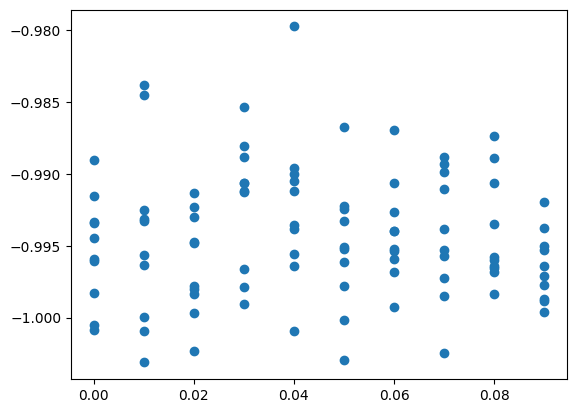

In [13]:
fig, ax = plt.subplots()
# ax.set_xscale("log", base=2)
ax.scatter(coeff_in, constant_out)

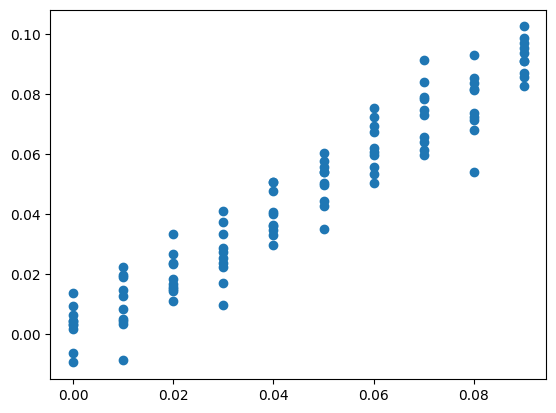

In [14]:
fig, ax = plt.subplots()
# ax.set_xscale("log", base=2)
ax.scatter(coeff_in, coeff_out)

In [15]:
print(np.mean(coeff_out[-10:]))
print(np.mean(constant_out[-10:]))

0.09249091512054317
-0.9964381222920602


### Extracting Exogenous Data

In [16]:
bin_sz = 0.01 # used throughout analysis, be careful!

In [17]:
flashes_table = nwb.intervals["flashes_presentations"]
# flashes_table = nwb.intervals["UniqueFFF_presentations"][0:14400:2]
flashes_table[:10]

,start_time,stop_time,stimulus_name,stimulus_block,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,
0,1285.60087,1285.851080,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3647, 1, timestamps pynwb.base.TimeSeries at..."
1,1287.60256,1287.852768,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3648, 1, timestamps pynwb.base.TimeSeries at..."
2,1289.60423,1289.854435,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3649, 1, timestamps pynwb.base.TimeSeries at..."
3,1291.60589,1291.856100,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3650, 1, timestamps pynwb.base.TimeSeries at..."
4,1293.60761,1293.857808,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3651, 1, timestamps pynwb.base.TimeSeries at..."
5,1295.60925,1295.859455,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3652, 1, timestamps pynwb.base.TimeSeries at..."
6,1297.61096,1297.861155,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3653, 1, timestamps pynwb.base.TimeSeries at..."
7,1299.61265,1299.862843,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3654, 1, timestamps pynwb.base.TimeSeries at..."
8,1301.61429,1301.864488,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3655, 1, timestamps pynwb.base.TimeSeries at..."


start: 1285.6008699215513 end: 1584.1002475386938
29849


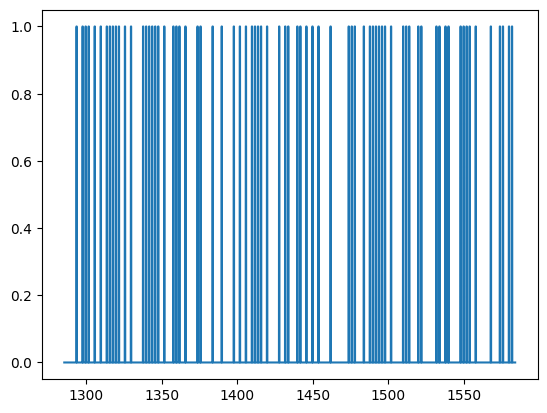

In [18]:
start_time = np.min(flashes_table.start_time)
end_time = np.max(flashes_table.stop_time)
time_axis = np.linspace(start_time, end_time, num=int((end_time-start_time)//bin_sz), endpoint=False)

print("start:",start_time,"end:",end_time)
print(len(time_axis))

interp_flashes = np.zeros(len(time_axis))
table_idx = 0
for i, ts in enumerate(time_axis):
    if ts > flashes_table.start_time[table_idx] and ts < flashes_table.stop_time[table_idx]:
        if float(flashes_table.color[table_idx]) == 1.0:
            interp_flashes[i] = 1.0
    elif ts < flashes_table.start_time[table_idx]:
        continue
    while ts > flashes_table.stop_time[table_idx]:
        table_idx += 1

# norm_flashes = (interp_flashes + 1) / 2
norm_flashes = interp_flashes
plt.plot(time_axis, norm_flashes)

In [19]:
# running_data = np.array(nwb.acquisition["raw_running_wheel_rotation"].data)
# running_timestamps = np.array(nwb.acquisition["raw_running_wheel_rotation"].timestamps)
# plt.plot(running_timestamps, running_data)
running_timestamps = []

### Extracting Spike Data

In [20]:
units = nwb.units

In [21]:
### use the electrodes table to devise a function which maps units to their brain regions

# select electrodes
channel_probes = {}

electrodes = nwb.electrodes
for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

# function aligns location information from electrodes table with channel id from the units table
def get_unit_location(row):
    return channel_probes[int(row.peak_channel_id)]

all_regions = set(get_unit_location(row) for row in units)
print(all_regions)

{'', 'PoT', 'CA2', 'VISrl', 'VISpm', 'PO', 'CA1', 'LGd', 'Eth', 'TH', 'VISam', 'VPM', 'LP', 'POL', 'VISp', 'APN', 'CA3', 'DG'}


In [22]:
### selecting units spike times

brain_regions = ['VISrl', 'VISal', 'VISpm', 'VISl', 'VISp']
# brain_regions = ["VIS", "VISp"]

# select units based if they have 'good' quality and exists in one of the specified brain_regions
units_spike_times = []
for location in brain_regions:
    location_units_spike_times = []
    for row in units:
        if get_unit_location(row) == location and row.quality.item() == "good":
            location_units_spike_times.append(row.spike_times.item())
    units_spike_times += location_units_spike_times

print(len(units_spike_times))

336


### Responsive Units

In [23]:
stim_times = []
for i, ts in enumerate(time_axis):
    if i == 0:
        continue
    if norm_flashes[i] == 1.0 and norm_flashes[i-1] == 0.0:
        stim_times.append(ts)

print(len(stim_times))

75


In [24]:
# bin size for counting spikes
# time_resolution = 0.01
time_resolution = bin_sz

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
window_start_time = -0.25
window_end_time = 0.25

In [25]:
def get_spike_matrix(n_units, bin_edges, n_trials, stim_times, units_spike_times):
    # 3D spike matrix to be populated with spike counts
    spike_matrix = np.zeros((n_units, len(bin_edges), n_trials))

    # populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
    for unit_idx in range(n_units):
        spike_times = units_spike_times[unit_idx]

        for stim_idx, stim_time in enumerate(stim_times):
            # get spike times that fall within the bin's time range relative to the stim time        
            first_bin_time = stim_time + bin_edges[0]
            last_bin_time = stim_time + bin_edges[-1]
            first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
            spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

            # convert spike times into relative time bin indices
            bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
            
            # mark that there is a spike at these bin times for this unit on this stim trial
            for bin_idx in bin_indices:
                spike_matrix[unit_idx, bin_idx, stim_idx] += 1

    spike_matrix = np.swapaxes(spike_matrix, 1, 2)
    return spike_matrix

In [26]:
# time bins used
n_bins = int((window_end_time - window_start_time) / time_resolution)
bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

# useful throughout analysis
n_units = len(units_spike_times)
n_trials = len(stim_times)

# calculate baseline and stimulus interval indices for use later
stimulus_onset_idx = int(-bin_edges[0] / time_resolution)
spike_matrix = get_spike_matrix(n_units, bin_edges, n_trials, stim_times, units_spike_times)
print(spike_matrix.shape)

(336, 75, 50)


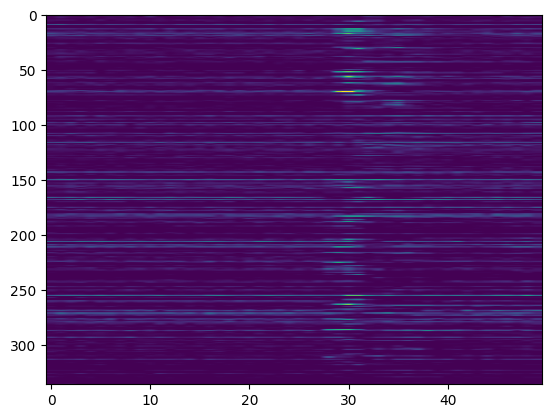

In [27]:
plt.imshow(np.mean(spike_matrix, axis=1), vmax=1, aspect="auto")

In [28]:
baseline_rates = np.mean(spike_matrix[:,:,:stimulus_onset_idx], axis=2)
baseline_stds = np.std(spike_matrix[:,:,:stimulus_onset_idx], axis=2)

mean_baseline_rate = np.expand_dims(np.mean(baseline_rates, axis=1), 1)
mean_baseline_stds = np.expand_dims(np.mean(baseline_stds, axis=1), 1) + 0.0001

zscores = (np.mean(spike_matrix, axis=1) - mean_baseline_rate) / mean_baseline_stds
print(zscores.shape)
max_zscores = np.max(zscores[:,stimulus_onset_idx:],axis=1)
mean_zscores = np.mean(zscores[:,stimulus_onset_idx:],axis=1)
# plt.imshow(zscores, vmin=-5, vmax=5)

(336, 50)


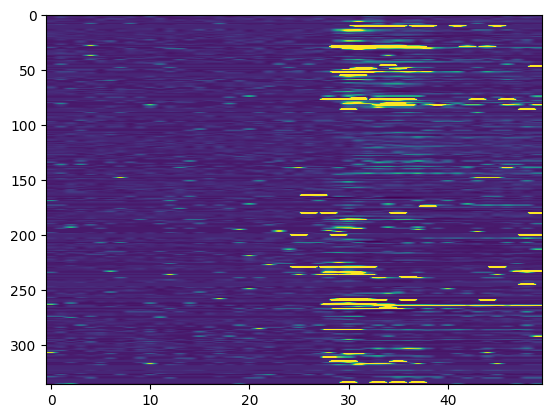

In [29]:
plt.imshow(zscores, vmax=5, aspect="auto")

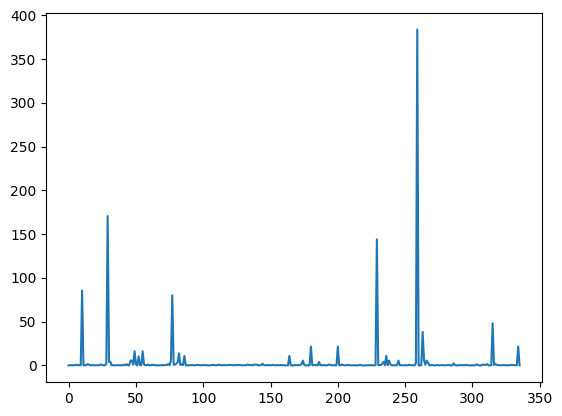

In [30]:
plt.plot(mean_zscores)

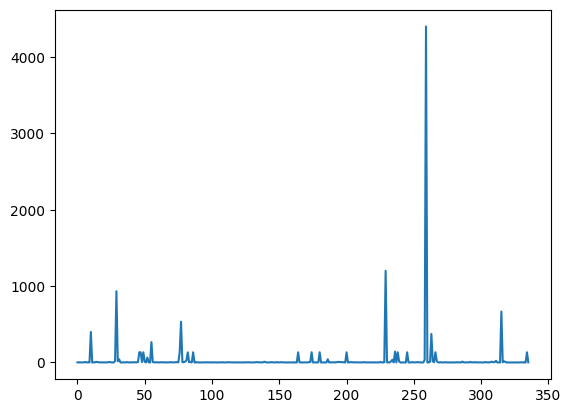

In [31]:
plt.plot(max_zscores)

In [32]:
units_spike_times = np.array(units_spike_times)
selected_units_spike_times = units_spike_times[mean_zscores > 10]
print(len(selected_units_spike_times))

17


C:\Users\carter.peene\AppData\Local\Temp\ipykernel_15104\705838605.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  units_spike_times = np.array(units_spike_times)


In [33]:
# useful throughout analysis
n_units = len(selected_units_spike_times)
n_trials = len(stim_times)
selected_spike_matrix = get_spike_matrix(n_units, bin_edges, n_trials, stim_times, selected_units_spike_times)
selected_spike_matrix.shape

(17, 75, 50)

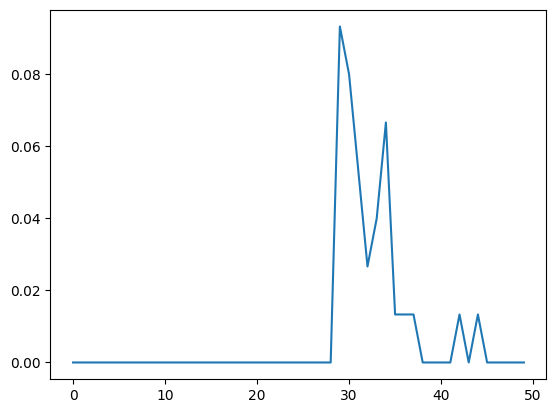

In [48]:
plt.plot(np.mean(selected_spike_matrix[1], axis=0))

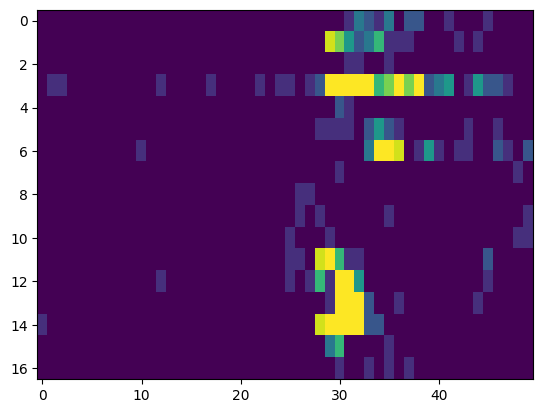

In [34]:
plt.imshow(np.mean(selected_spike_matrix, axis=1), aspect="auto", vmax=0.1, interpolation="none")

### Aligning Running

In [35]:
# f = interpolate.interp1d(flashes_times, flashes, axis=0, kind="nearest", fill_value="extrapolate")
# interp_flashes = f(time_axis)
# print(len(interp_flashes))
# plt.plot(time_axis, interp_flashes)

In [36]:
# f = interpolate.interp1d(running_timestamps, running_data, axis=0, kind="linear", fill_value="extrapolate")
# interp_running = f(time_axis)
# norm_running = interp_running / np.max(np.abs(interp_running))
# print(len(norm_running))
# plt.plot(time_axis, norm_running)

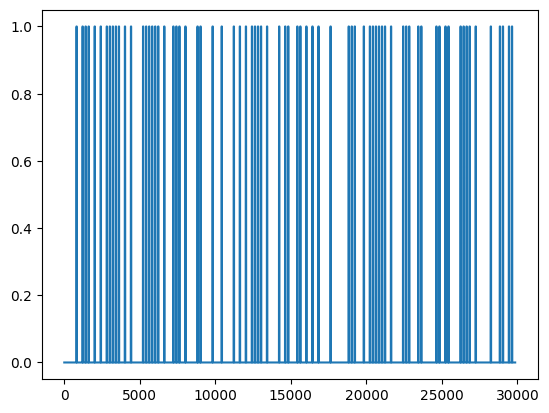

In [37]:
mod_coef = 0.5
# exog = (1-mod_coef)*interp_flashes + mod_coef*norm_running
# exog = (interp_flashes + 1 ) / 2
exog = interp_flashes
plt.plot(exog)

### Generating Filters

(29849, 51)


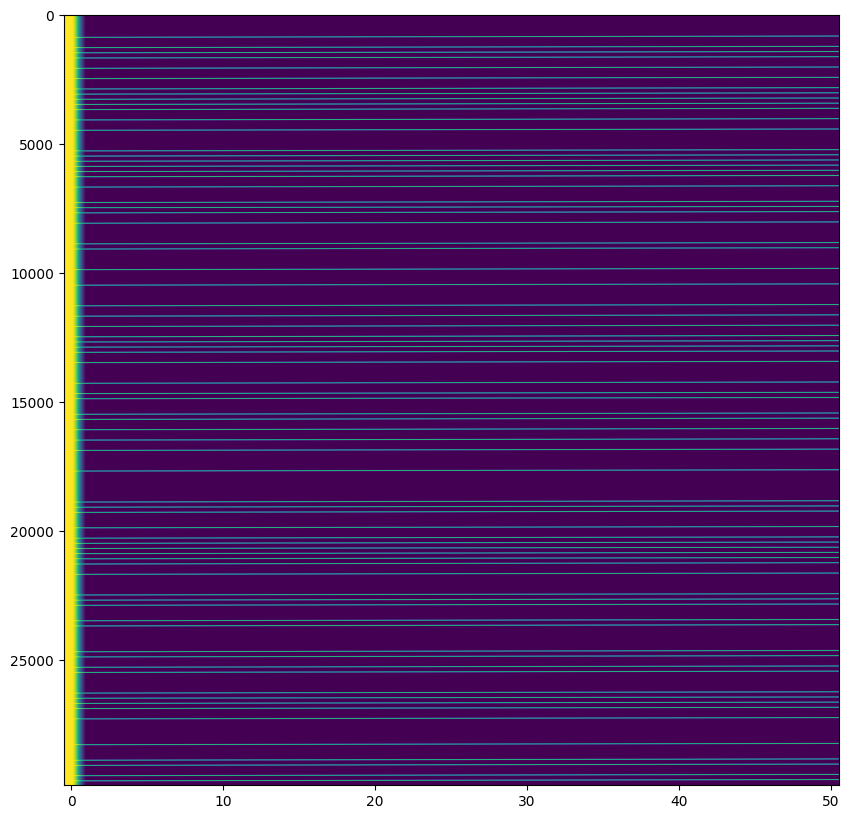

In [38]:
filter_length = 50
design_mat = build_design_mat(interp_flashes, d=filter_length)
print(design_mat.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(design_mat, aspect="auto")

In [39]:
filters = []
constants = []
# fig, axes = plt.subplots(1,3)
for i, spike_times in enumerate(selected_units_spike_times):
    # bin spikes where bins line up with the interpolated flashes timestamps
    these_spikes_binned, _ = np.histogram(spike_times, bins=len(time_axis), range=(start_time,end_time))
    # axes[i].plot(these_spikes_binned)
    try:
        const, filt = fit_lnp(design_mat, these_spikes_binned, d=filter_length, lam=2**8)
        filters.append(filt)
        constants.append(const)
    except:
        filters.append([])
        constants.append(np.nan)

y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)
y: (29849,) X: (29849, 51) x0: (51,)


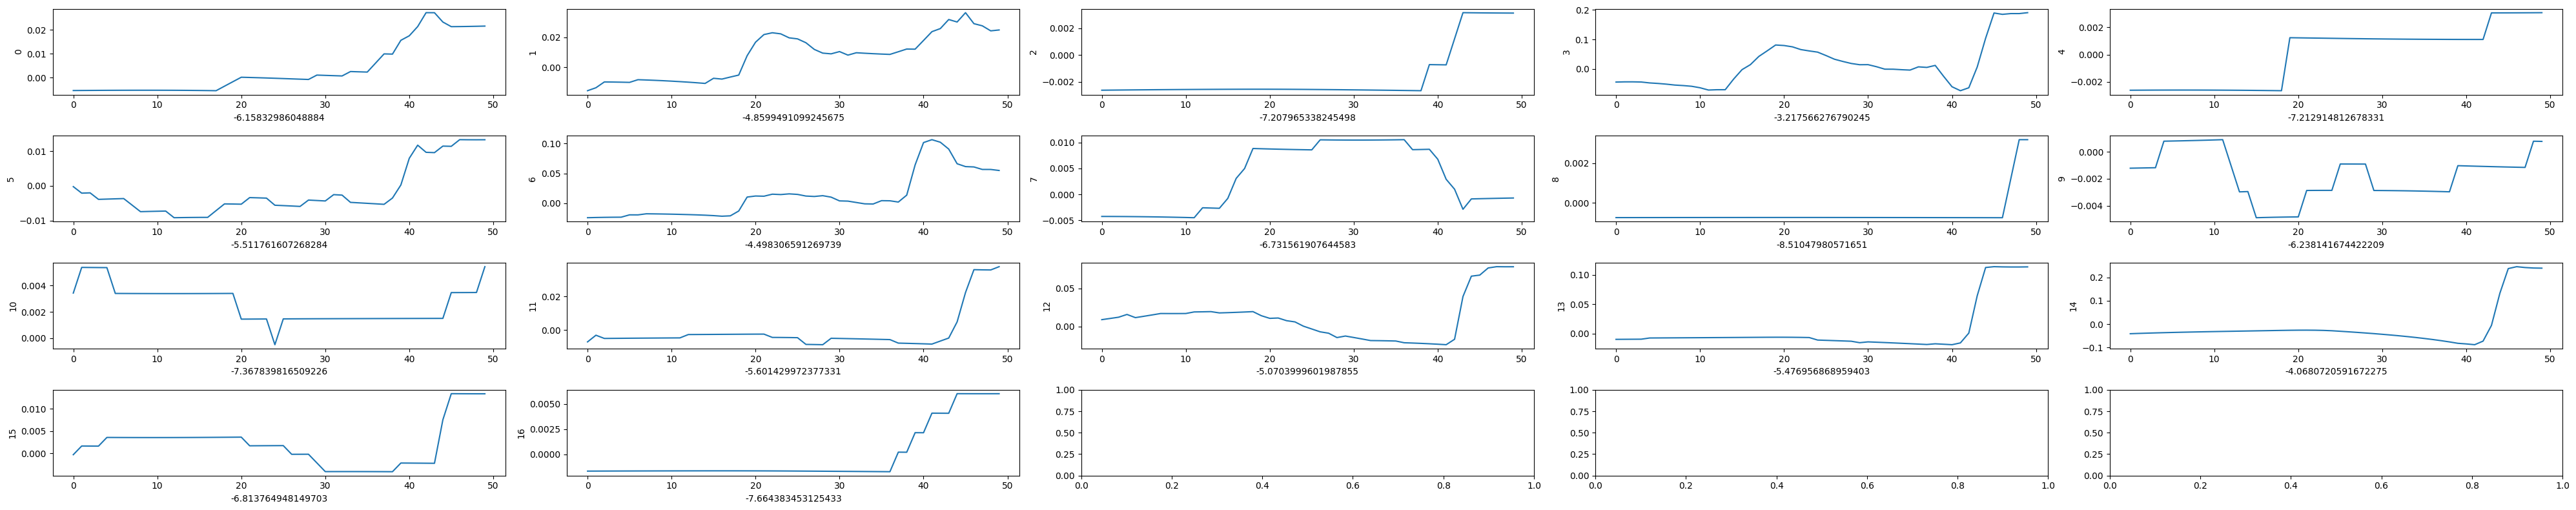

In [40]:
n_cols=5

n_rows = ceil(len(filters)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(40,2*n_rows))
if len(axes.shape) == 1:
    axes = axes.reshape((1, axes.shape[0]))

for i in range(len(filters)):
    f = filters[i]
    c = constants[i]
    row = i // n_cols
    col = i % n_cols
    axes[row][col].plot(f)
    axes[row][col].set_ylabel(i)
    axes[row][col].set_xlabel(c)

fig.tight_layout()
plt.show()

In [41]:
unit_idx = 134
spike_times = units_spike_times[unit_idx]
print(spike_times)

[3.93721260e+00 6.63672001e+00 7.51182241e+00 ... 9.67902317e+03
 9.67909964e+03 9.67911011e+03]


In [42]:
num_spikes = len(time_axis)
# spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
spikes_binned,_ = np.histogram(spike_times, time_axis)

### Compare to real cell activity

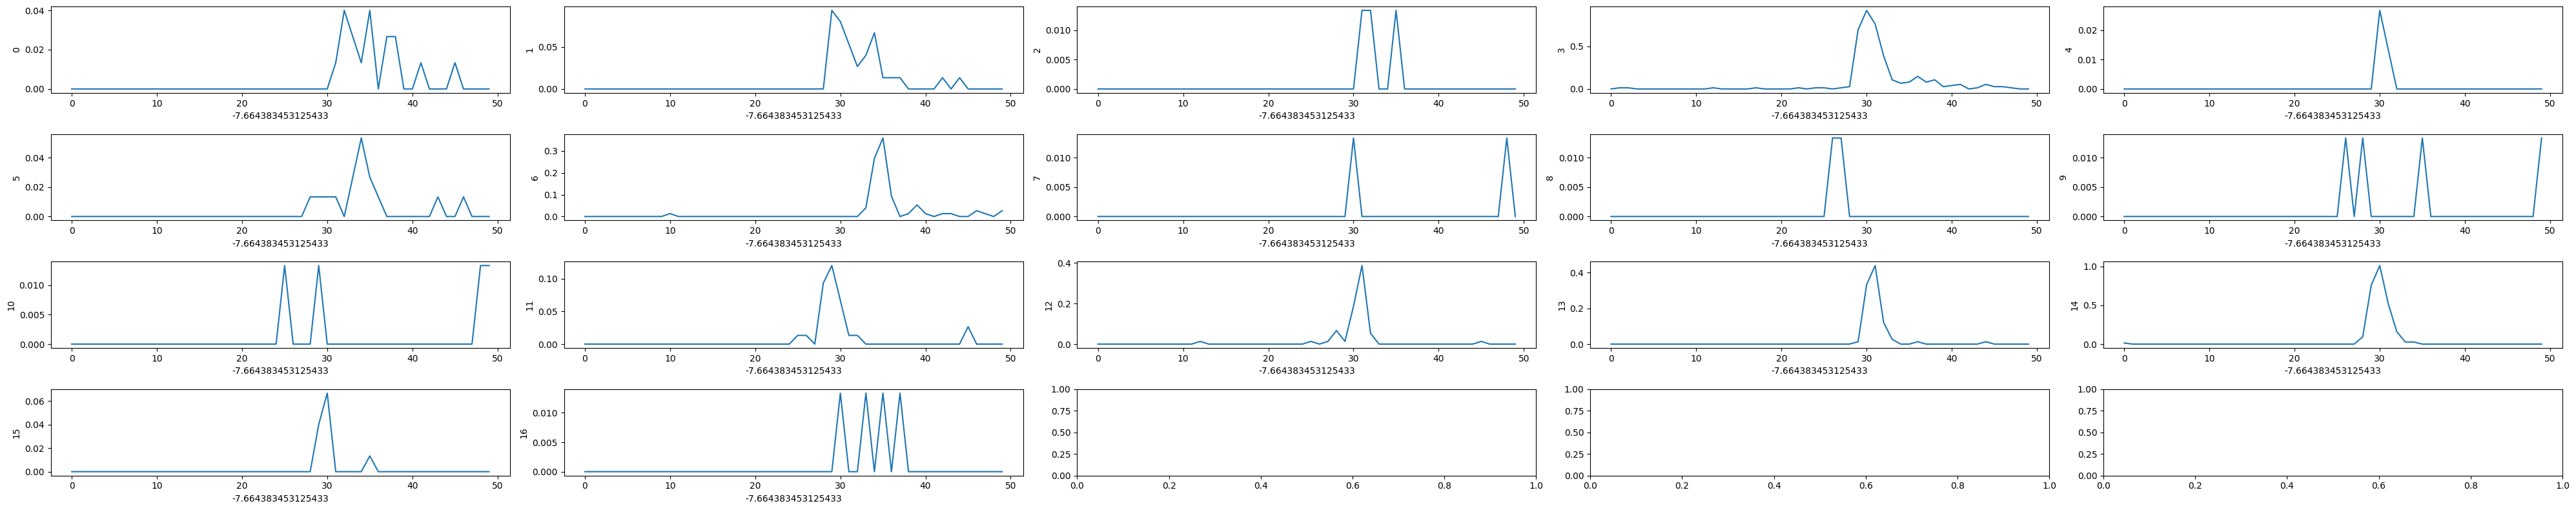

In [49]:
n_cols=5

n_rows = ceil(len(selected_spike_matrix)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(40,2*n_rows))
if len(axes.shape) == 1:
    axes = axes.reshape((1, axes.shape[0]))

for i in range(len(selected_spike_matrix)):
    avg_response = np.mean(selected_spike_matrix[i], axis=0)

    row = i // n_cols
    col = i % n_cols
    axes[row][col].plot(avg_response)
    axes[row][col].set_ylabel(i)
    axes[row][col].set_xlabel(c)

fig.tight_layout()
plt.show()

### Predict Activity

In [43]:
ntfilt = 1
num_time_bins = len(exog)-1
design_mat = get_design_mat(ntfilt, exog, num_time_bins)
design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones

res = fit_lnp(design_mat_offset, spikes_binned, bin_sz=0.01, lam=0)
constant, filter = res[0], res[1:]
print(constant, filter)

NameError: name 'get_design_mat' is not defined

In [ ]:
def predict(X, weights, constant, bin_sz=1):
    y = np.exp(X @ weights + constant) * bin_sz
    return y

def predict_spikes(X, weights, constant, bin_sz=1):
    rate = predict(X, weights, constant, bin_sz)
    spks = np.random.poisson(np.matrix.transpose(rate))
    return spks

In [ ]:
### predict
predictions = []
for j in range(100):
    predictions.append(predict_spikes(design_mat, filter, constant))

In [ ]:
fig, axes = plt.subplots(1,6, figsize=(30,5))

prob_predicted = predict(design_mat, filter, constant, bin_sz=1)
spikes_predicted = predict_spikes(design_mat, filter, constant, bin_sz=1)
avg_predicted = np.mean(predictions, axis=0)

axes[0].plot(spikes_binned[0:1000])
axes[1].plot(filter)
axes[2].plot(prob_predicted[0:1000])
axes[3].plot(spikes_predicted[0:1000])
axes[4].plot(avg_predicted[0:1000])
axes[5].plot(spikes_binned[0:1000])
axes[5].plot(spikes_predicted[0:1000])

print(r2_score(spikes_binned, spikes_predicted))
print(np.sum(spikes_binned) / len(spikes_binned))
print(np.sum(spikes_predicted) / len(spikes_predicted))

plt.show()

In [ ]:
mse2 = np.mean((spikes_binned-spikes_predicted)**2)  # mean squared error, with offset
rss = np.mean((spikes_binned-np.mean(spikes_binned))**2)    # squared error of spike train
print('Training perf (R^2): lin-gauss GLM, w/ offset: {:.2f}'.format(1-mse2/rss))